<a href="https://colab.research.google.com/github/dirudiez/TFM_DiegoRudiez/blob/main/Binario_FL_resnet18_BalanceoSklearn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://notebooks.githubusercontent.com/view/ipynb?browser=chrome&color_mode=auto&commit=550a08945499aa9ff119547dc4aefbbeec0e5dbf&device=unknown&enc_url=68747470733a2f2f7261772e67697468756275736572636f6e74656e742e636f6d2f77616c6b776974686661737461692f77616c6b776974686661737461692e6769746875622e696f2f353530613038393435343939616139666631313935343764633461656662626565633065356462662f6e62732f30325f766973696f6e2e65787465726e616c2e74696d6d2e6970796e62&logged_in=false&nwo=walkwithfastai%2Fwalkwithfastai.github.io&path=nbs%2F02_vision.external.timm.ipynb&platform=android&repository_id=295613905&repository_type=Repository&version=98

En este cuaderno probaremos la arquitectura efficientnet_b3 para ver si obtenemos unos mejores resultados.

## Librerías

In [2]:
!pip install fastai==2.6.3 -Uq
!pip install timm

#Reiniciamos el entorno de ejecución automáticamente
import IPython
IPython.Application.instance().kernel.do_shutdown(True)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


{'restart': True, 'status': 'ok'}

In [2]:
!pip install wwf -q
# !pip install nbdev

In [1]:
from fastai.vision.all import *

#Estas liberías son para las arquitectuas EffiecientNet e Inception
import timm
from wwf.utils import *
from wwf.vision.timm import *

## Dataset

En este caso estamos usando el dataset que ha sido preprocesados mediante el método de recorte

In [2]:
!wget https://www.dropbox.com/s/o1eaoae59qgdo4i/Training_Set_Pre.zip?dl=0 --no-verbose -O train.zip
!wget https://www.dropbox.com/s/5od5cac9xhxlcwu/Test_Set_Pre.zip?dl=0 --no-verbose -O test.zip
!wget https://www.dropbox.com/s/gjz445xm4oddfus/Evaluation_Set_Pre.zip?dl=0 --no-verbose -O val.zip

2022-06-19 08:02:45 URL:https://uc32435aec7ed506242e2eaf86da.dl.dropboxusercontent.com/cd/0/inline2/Bnd3PZNMEJXFg-uzGntU5qG6gcqR9IzRbSAiRZ4z4mOPfqQP0_7ICL2AbxbmtH8SiZp4JJQQdyPihAgB92Hi7K9W8uggY84gvcvOSJmW0pcEX4gl8cMYIPgJE8QTRiQ0zJ1ydE_muv1-YHVxwDMMhpGaHSzRVLpCA7UxXIFLAZLWKNUECQz-wpACkySwLV4dsrXXaU9DVGXvXdFO6xYyxfuvFYkdOQiD63BwjwD_7F0F32_SoH6vCtpr3Ss2A39zs0swMkvELVxRFFazcyRbudJ9tcR8xxueC7fZclY1xtUEwRoHBYFxMRJIQbB7OoB-jGPknJ9gcupp1ehMmvM9rH0ClG4Iz1kRs_8h0qZsyTIXjSgrbFFtmnKzoMCu1y7A_4rlopEGzMUrHaEEZTj5pEkRsJEZkp3uqjkRH6Obik4Rhw/file [138777773/138777773] -> "train.zip" [1]
2022-06-19 08:02:47 URL:https://uc136b675f9523ff3408fc3732c4.dl.dropboxusercontent.com/cd/0/inline2/BnfD4QQsTkjlhVcRPJczYVH931t6YRJtz50k-DivXNuIntJ8PGhYgo-z8czfaYmAi2A6MEcMyqGi226yGN7RnBfV-iVjCuBsDxC_d-h-W9MVq6GxjAVTvTR-xj8K9sDDlgM8vR-j3lfKGZYFsp3VoyWZOhnKSfND76kp8cpQb14GxTGmFPE_8-1kn8RbSOxNkhQPUMBdPF8EnLyjNlabC6hA0tOKvTHEsRTBPGhJh6k318R_smcDAFQ7njL7gF_v9tU02mR7sBspGXsTeuhzyxu2LMZs2F1IgQxoHHTOdJGbNy4bfcdEYAMN9QcV7_lgVPq

In [3]:
# !rm -rvf Training_Set_Pre
!unzip -qq train.zip #-qq no verbose
!unzip -qq test.zip
!unzip -qq val.zip

In [4]:
#Método para crear estructura de directorios
def crearEstructura(nombreDataset, clases):
  !mkdir "$nombreDataset"
  !mkdir "$nombreDataset"/test
  !mkdir "$nombreDataset"/train
  !mkdir "$nombreDataset"/val
  for x in clases:
    !mkdir "$nombreDataset"/train/"$x"
    !mkdir "$nombreDataset"/test/"$x"
    !mkdir "$nombreDataset"/val/"$x"

In [5]:
crearEstructura('dataset', ['normal', 'enfermedad'])

In [6]:
trainPath = Path('Training_Set_Pre/')
testPath  = Path('Test_Set_Pre/')
valPath  =  Path('Evaluation_Set_Pre/')

In [7]:
df_train = pd.read_csv(str(trainPath) + '/train.csv')
df_test = pd.read_csv(str(testPath) + '/test.csv')
df_val = pd.read_csv(str(valPath) + '/val.csv')

#### Mover imágenes:

In [8]:
import shutil
import uuid

def moverImg(df, pathO, pathD):
  for id, enf in zip(df['ID'], df['Disease_Risk']):
    if(int(enf)==0):
        shutil.copy(pathO + '/' + str(id) + '.png', pathD + '/normal/' + str(uuid.uuid1()) + '.png')
    else:
        shutil.copy(pathO + str(id) + '.png', pathD + '/enfermedad/' + str(uuid.uuid1()) + '.png')

In [9]:
path = Path('dataset')

## Balanceo

In [10]:
from sklearn.utils import resample

In [11]:
df_majority = df_train[df_train.Disease_Risk==1] #mayoria de instacias con enfermedad respecto a sin ella.
df_minority = df_train[df_train.Disease_Risk==0]

In [12]:
# Aumentar la muestra de la clase minoritaria
# Aumentar la muestra de la clase minoritaria
df_minority_upsampled = resample(df_minority,
                                 replace=True,     # muestra con remplazamiento
                                 n_samples=960,    # número de muestras de la clase mayoritaria
                                 random_state=42) # semilla para que los resultados sean reproducibles

# Disminuir la clase mayoritaria
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # muestra sin remplazamiento
                                 n_samples=960,     # número de muestras de la clase minoritaria
                                 random_state=42) # semilla para que los datos sean reproducibles
                               
# Combinar el nuevo grupo con el grupo original mayoritario
df_train = pd.concat([df_majority_downsampled, df_minority_upsampled])
df_train = df_train.reset_index(drop=True)

# Mostrar el número de instancias en cada clase
df_train.Disease_Risk.value_counts()

1    960
0    960
Name: Disease_Risk, dtype: int64

In [13]:
len(df_minority_upsampled.ID.unique())

359

**Una vez que tenemos el dataframe balanceado comenzamos a copiar las imágenes a las carpetas que corresponda.**

In [14]:
moverImg(df_train, str(trainPath) + '/Training/', str(path)  + '/train')
moverImg(df_test, str(testPath) + '/Test/', str(path)  + '/test')
moverImg(df_val, str(valPath) + '/Validation/', str(path)  + '/val')

## Cargando el dataset

In [15]:
db = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(train_name='train', valid_name='val'),
                 get_y=parent_label,
                 item_tfms = Resize(256),
                 batch_tfms=aug_transforms(size=128,min_scale=0.75))

In [16]:
dls = db.dataloaders(path,bs=128)

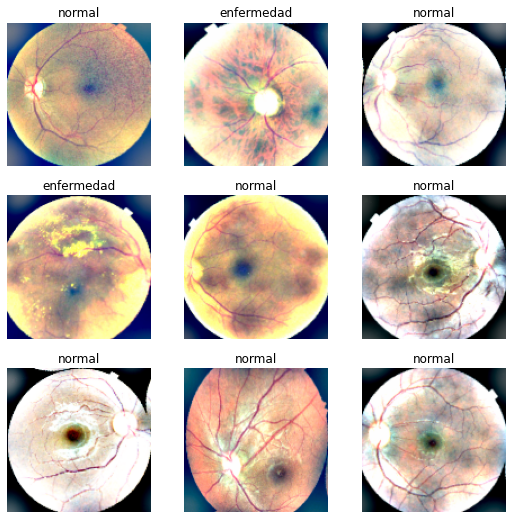

In [17]:
dls.show_batch()

In [19]:
callbacks = [
    ShowGraphCallback(),
    EarlyStoppingCallback(patience=20),
    SaveModelCallback(fname='modelResnet18')
]

In [20]:
metrics=[ accuracy, Precision(), Recall(), F1Score(), error_rate ]
learn = cnn_learner(dls,resnet18, metrics=metrics, loss_func=FocalLoss(), cbs=callbacks).to_fp16()

/usr/local/lib/python3.7/dist-packages/fastai/vision/learner.py:265: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

SuggestedLRs(minimum=0.010000000149011612, steep=6.309573450380412e-07, valley=0.0006918309954926372, slide=0.009120108559727669)

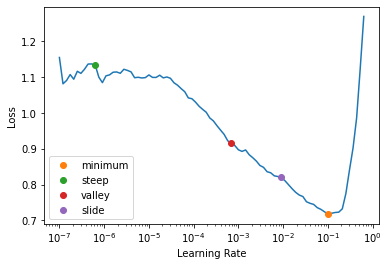

In [21]:
learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

## Entrenamos el modelo

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,error_rate,time
0,1.106788,0.404512,0.646875,0.219512,0.268657,0.241611,0.353125,00:09


Better model found at epoch 0 with valid_loss value: 0.4045117497444153.


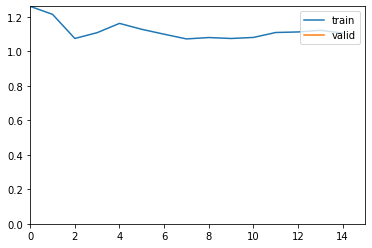

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,error_rate,time
0,1.050872,0.446895,0.604688,0.242424,0.417910,0.306849,0.395312,00:09
1,1.018793,0.462621,0.590625,0.241935,0.447761,0.314136,0.409375,00:09
2,1.037126,0.442629,0.604688,0.257143,0.470149,0.332454,0.395312,00:09
3,1.023147,0.388806,0.651563,0.289100,0.455224,0.353623,0.348437,00:09
4,1.011925,0.415137,0.621875,0.273109,0.485075,0.349462,0.378125,00:09
5,1.009504,0.381618,0.643750,0.280374,0.447761,0.344828,0.356250,00:09
6,1.001278,0.382893,0.648438,0.286385,0.455224,0.351585,0.351562,00:09
7,0.990527,0.368882,0.653125,0.298165,0.485075,0.369318,0.346875,00:09
8,0.972247,0.377170,0.656250,0.317797,0.559701,0.405405,0.343750,00:10
9,0.950920,0.364347,0.668750,0.330435,0.567164,0.417582,0.331250,00:09


Better model found at epoch 0 with valid_loss value: 0.44689497351646423.


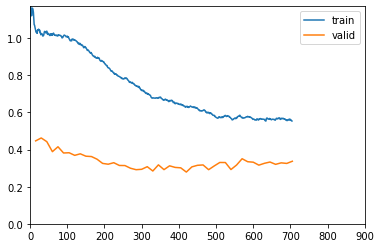

Better model found at epoch 2 with valid_loss value: 0.4426294267177582.
Better model found at epoch 3 with valid_loss value: 0.38880589604377747.
Better model found at epoch 5 with valid_loss value: 0.38161763548851013.
Better model found at epoch 7 with valid_loss value: 0.3688816428184509.
Better model found at epoch 9 with valid_loss value: 0.36434656381607056.
Better model found at epoch 10 with valid_loss value: 0.362419068813324.
Better model found at epoch 11 with valid_loss value: 0.3481939435005188.
Better model found at epoch 12 with valid_loss value: 0.3254980146884918.
Better model found at epoch 13 with valid_loss value: 0.3210916221141815.
Better model found at epoch 15 with valid_loss value: 0.31439581513404846.
Better model found at epoch 16 with valid_loss value: 0.31392139196395874.
Better model found at epoch 17 with valid_loss value: 0.29941198229789734.
Better model found at epoch 18 with valid_loss value: 0.29163068532943726.
Better model found at epoch 21 with v

In [22]:
%%time
learn.fine_tune(60,base_lr=1e-5)

## Evaluando el Modelo

In [24]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(256),
                 batch_tfms=aug_transforms(size=128,min_scale=0.75))
dlsTest = dbTest.dataloaders(path,bs=128)

In [25]:
learn.dls = dlsTest

Obtenemos una accuracy de 0.78.

In [26]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.7734375.


(#6) [0.140213280916214,0.7734375,0.46745562130177515,0.5895522388059702,0.5214521452145215,0.2265625]

Exportamos el modelo:

In [27]:
learn.to_fp32()
learn.export('Binario_FL_resnet18_BalanceoSklearn.pkl')

## Interpretación del modelo

/usr/local/lib/python3.7/dist-packages/fastai/vision/learner.py:265: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")


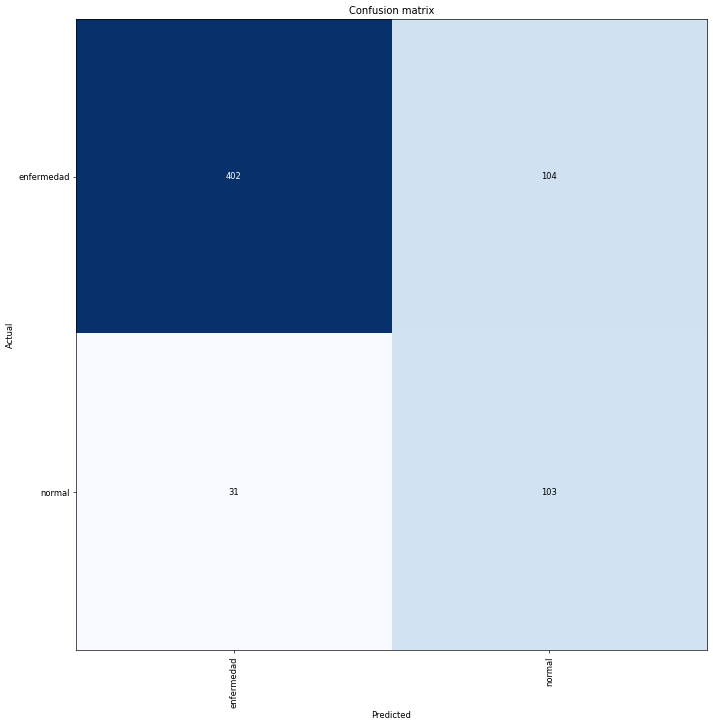

In [28]:
learn_inf = load_learner('Binario_FL_resnet18_BalanceoSklearn.pkl')
learnInterp = cnn_learner(dls,resnet18).to_fp16()
learnInterp.model = learn_inf.model
interp = ClassificationInterpretation.from_learner(learnInterp)
interp.plot_confusion_matrix(figsize=(12,12),dpi=60)